# Social Reward Modeling

Social reward task computational modeling from the DSCN Lab Social Connection (SCONN) project. These analyses will propose computational models that aim to explain participants' behavior during a task in which they learn about a similar peer, dissimilar peer, and a computer. Similarity is defined as common interest from a survey that asked participants whether they enjoy certain things (e.g. reading, hiking, etc.).

## Set Up

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt


### Set Paths

In [3]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
#proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
data_dir = os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data')
outp_dir = os.path.join(proj_dir, 'derivatives', 'rl_modeling', 'event_files')

os.chdir(proj_dir)

### Find Participants

In [4]:
# Import participant id data
subj_df = pd.read_csv(proj_dir+'participants.tsv', sep='\t')

# Fix participant IDs to match the directories in the data folder (e.g. sub-SCN101 -> SCN_101)
subj_df['participant_id'] = [x[4:7]+'_'+x[7:] for x in subj_df['participant_id']]

# Create subject list
subj_list = subj_df['participant_id'].unique()


print('Found '+str(len(subj_list))+' participants')

Found 133 participants


## Model Designs

### Model 1: Generative Rescorla Wagner

This is a generative model which assumes a common learning rate for all participants. The model takes as input a trial list, which contains information about the conditions (similar, dissimilar, or computer), and feedback (thumbs up or down) for each trial, and returns the following outputs: expected value of the three conditinos on each trial, and reward prediction error. There is no value calculation based on choices or reaction times to a button press. 

In [5]:
def rw_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))

    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    
    for t in range(len(trial_list)):
        # Capture trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['RPE'] = RPE
    RL_output['RT'] = np.nan
    
    return RL_output

### Model 2: Rescorla Wagner + Random RT
This model uses reaction time to calculate the value of each condition, for each trial. However, the reaction times are simulated to be random. This serves as the null model. 

In [6]:
def rw_randrt_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))

    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5    
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))
    intercept = np.random.rand()

    # Define minimum and maxium reaction time for random sampling
    min_rt = 0.25
    max_rt = 2.0
    
    
    for t in range(len(trial_list)):
        # Capture trial info
        cond_t = trial_list.loc[t, 'Peer']

        # Create a random RT
        RT[t] = beta * np.random.uniform(min_rt,max_rt) + intercept

        # Calculate the current value
        #value_t = V.loc[t, cond_t] + np.log(RT[t])
        value_t = V.loc[t, cond_t]

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t
        
        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['Feedback'] = trial_list['Feedback']
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 3: Rescorla Wagner + Value Differentiation RT
- Reaction time is calculated from value, but is dependent on how well each condition can be differentiated
- Once conditions are learned to be more seperate, reaction times will be faster
- https://pmc.ncbi.nlm.nih.gov/articles/PMC8930195/
    - RTt = -B|Vpst - Vpdt - Vct| + error
        - B = 1
        - Vpst = value of peer similar at t
        - Vpdt = value of peer dissimilar at t
        - Vct = value of computer at t
        - error = Gaussian random noise, with mean = 1 and SD = 5 * SD of |Vpst - Vpdt - Vct|
- Note: I don't see how this model is any different from a model which predicts participants to just get faster because of practice effects.

In [7]:
def rw_rtvaldiff_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Set model parameters
    mu = 0
    
    for t in range(len(trial_list)):
        # Capture the trial info
        cond_t = trial_list.loc[t, 'Peer']

        # Create a RT based on the value of each condition
        cond_diff = np.abs(V.loc[t, 'SimPeer'] - V.loc[t, 'DisPeer'] - V.loc[t, 'Computer'])
        sigma = np.std(V['SimPeer'] - V['DisPeer'] - V['Computer'])
        RT[t] = beta * np.abs(np.abs(cond_diff) + np.random.normal(mu, 0.05))
        #RT[t] = np.abs(np.random.uniform(0.25,2) - V.loc[t, cond_t])

        # Calculate the current value
        #value_t = V.loc[t, cond_t] + np.log(RT[t])
        value_t = V.loc[t, cond_t]

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 4: Rescorla Wagner + RT Value
- Reaction time is directly based on the value of the condition
- Hypothesis: Higher value and faster reaction time for the similar peer, low value and slower reaction time for dissimilar peer, and neutral value and no change in reaction time for computer.

In [8]:
def rw_rt_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Set model parameters
    intercept = np.random.rand()
    
    for t in range(len(trial_list)):
        # Capture the trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]

        # Create a RT based on the value of each condition
        RT[t] = beta * -1 * value_t + intercept

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 5: Rescorla Wagner + RT Social Value
- Reaction time is directly based on the value of the condition
- Higher value and lower reaction times for the social peers rather than computer

In [9]:
def rw_rtsocial_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Set model parameters
    intercept = np.random.rand()
    
    for t in range(len(trial_list)):
        # Capture the trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]
        
        if cond_t == 'DisPeer':
            beta = beta * -1
        elif cond_t == 'Computer':
            beta = 0
        
        # Create a RT based on the value of each condition
        RT[t] = beta * -1 * value_t + intercept

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model 6: RW + RT Value + Item Value
- Built off of Model 4
- The explicit value of each item (as indicated by a participant pre-task survey) amplifies the value

In [10]:
def rw_item_model(trial_list, alpha, beta, neg_reward=False):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    # Create initial variables
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    RPE = np.empty(len(trial_list))
    RT = np.empty(len(trial_list))

    # Set model parameters
    intercept = np.random.rand()
    
    for t in range(len(trial_list)):
        # Capture the trial info
        cond_t = trial_list.loc[t, 'Peer']
        value_t = V.loc[t, cond_t]
        item_val_t = trial_list.loc[t, 'Interest']

        # Create a RT based on the value of each condition
        RT[t] = beta * -1 * value_t * item_val_t + intercept

        # Calculate RPE
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        elif feedback_t < 0 and not neg_reward:  # If feedback is negative, make it 0
            RPE[t] = 0 - value_t
        else:
            RPE[t] = feedback_t - value_t

        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['Peer'] = trial_list['Peer']
    RL_output['Interest'] = trial_list['Interest']
    RL_output['RPE'] = RPE
    RL_output['RT'] = RT
    
    return RL_output

### Model Summaries

| Model | Parameters | Hypothesis |
| ----- | ---------- | ---------- |
| Model 1 | V | No RT |
| Model 2 | random RT | value is not dependent on reaction time |
| Model 3 | RT | reaction time increases as participants learn the condition values |
| Model 4 | RT | negative relationship between value and reaction time |
| Model 5 | RT + condition | faster reaction times for social > computer |
| Model 6 | RT + item value | negative relationship between value and reaction, amplified by inherent item value |

**Note:** Still editing this

## Simulate Data

### Define simulation function
This function takes in the number of trials as input and outputs a simulated task with the correction distribution of trial types. 

In [11]:
def simulate_data(n_trials):
    # Define the proportion of positive and negative feedback for each peer condition
    # 96 is used as the denominator bceause that is the number of trials in the task, but
    # more trials can be simulated here
    prop_ps_pos = 24/96
    prop_ps_neg = 8/96
    prop_pd_pos = 8/96
    prop_pd_neg = 24/96
    prop_c_pos = 16/96
    prop_c_neg = 16/96

    # Define an empty dataframe
    peer_data = []
    fb_data = []

    # Add feedback data for positive and negative feedback
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_ps_pos * n_trials))
    peer_data = peer_data + (['SimPeer'] * int(prop_ps_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_ps_neg * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_pd_pos * n_trials))
    peer_data = peer_data + (['DisPeer'] * int(prop_pd_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_pd_neg * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_pos * n_trials))
    fb_data = fb_data + ([1] * int(prop_c_pos * n_trials))
    peer_data = peer_data + (['Computer'] * int(prop_c_neg * n_trials))
    fb_data = fb_data + ([-1] * int(prop_c_neg * n_trials))

    sim_data_dict = {'Peer': peer_data, 'Feedback': fb_data} 
    sim_data = pd.DataFrame(sim_data_dict)

    # Create item interest data
    n_pos_data = len(sim_data[sim_data['Feedback'] == 1])
    n_neg_data = len(sim_data[sim_data['Feedback'] == -1])

    interest_pos = [1] * int(.75 * n_pos_data) + [2] * int(.25 * n_pos_data)
    #interest_pos = interest_pos + [[np.random.choice([1,2])] * n_pos_data - len(interest_pos)]
    interest_neg = [-1] * int(.75 * n_neg_data) + [-2] * int(.25 * n_neg_data)
    #interest_neg = interest_neg + [[np.random.choice([1,2])] * n_neg_data - len(interest_neg)]

    # Randomize
    np.random.shuffle(interest_pos)
    np.random.shuffle(interest_neg)

    sim_data['Interest'] = 0
    sim_data.loc[sim_data[sim_data['Feedback'] == 1].index,'Interest'] = interest_pos
    sim_data.loc[sim_data[sim_data['Feedback'] == -1].index,'Interest'] = interest_neg

    sim_data = sim_data.sample(frac=1).reset_index(drop=True)

    return(sim_data)

### Define model simulation function
This function takes in a particular model and runs a simulation with the appropriate parameters.

In [12]:
def run_rl_model(model, alpha, beta, neg_reward, n_trials, n_sims):
    # Create empty dataframe to store data
    model_data = pd.DataFrame()

    for n_sim in range(n_sims):
        # Create simulated data
        sim_data = simulate_data(n_trials)
        
        # Run models
        model_data_temp = model(sim_data, alpha, beta, neg_reward=neg_reward)
    
        model_data_temp['n_sim'] = n_sim
    
        model_data = pd.concat([model_data, model_data_temp])

    # Turn index into time point
    model_data['trial'] = model_data.index
    model_data_long = pd.melt(model_data, id_vars=['n_sim','Peer','RPE','RT','trial','Interest'], 
                              var_name='Condition',
                              value_vars=['SimPeer','DisPeer','Computer'], value_name='Value')

    return(model_data, model_data_long)


### Simulate models

In [13]:
n_sims = 1000
n_trials = 96

model_1, model_1_long = run_rl_model(model=rw_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_2, model_2_long = run_rl_model(model=rw_randrt_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_3, model_3_long = run_rl_model(model=rw_rtvaldiff_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_4, model_4_long = run_rl_model(model=rw_rt_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_5, model_5_long = run_rl_model(model=rw_rtsocial_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)
model_6, model_6_long = run_rl_model(model=rw_item_model, alpha=0.1, beta=1, neg_reward=False,
                                     n_trials=n_trials, n_sims=n_sims)


### Plot model parameters

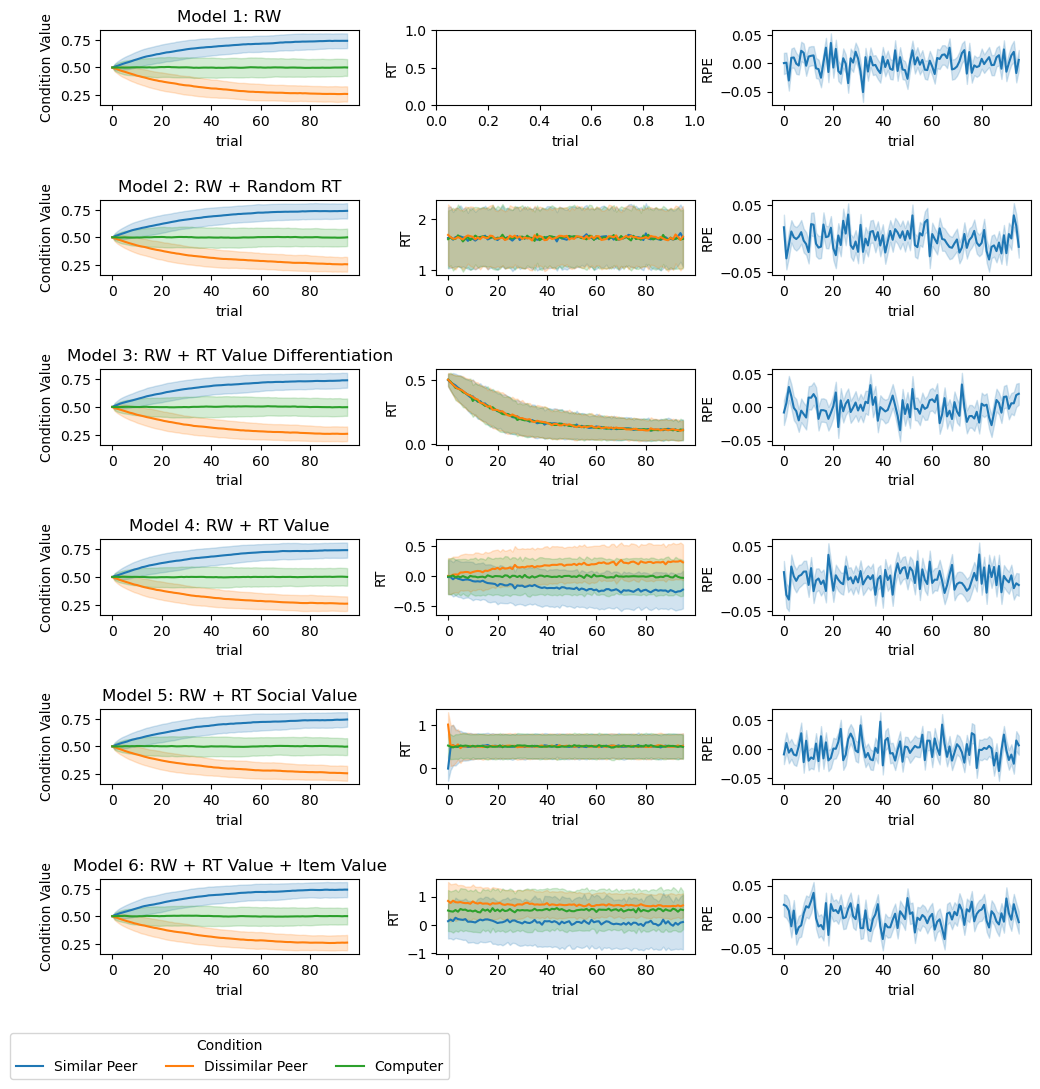

In [14]:
relv_models = [model_1_long, model_2_long, model_3_long, 
               model_4_long, model_5_long, model_6_long]
relv_titles = ['Model 1: RW', 'Model 2: RW + Random RT', 'Model 3: RW + RT Value Differentiation',
               'Model 4: RW + RT Value', 'Model 5: RW + RT Social Value', 
               'Model 6: RW + RT Value + Item Value']

palette = {'SimPeer':sns.color_palette()[0],
           'DisPeer':sns.color_palette()[1],
           'Computer':sns.color_palette()[2]}

fig, axs = plt.subplots(len(relv_models),3, figsize=(12,2*len(relv_models)))
plt.subplots_adjust(wspace=0.3, hspace=1.25)

for i in range(len(relv_models)):
    # Plot Value
    sns.lineplot(data=relv_models[i], x='trial', y='Value', dashes=False, 
                 hue='Condition', errorbar='sd', ax=axs[i,0])
    axs[i,0].set_ylabel('Condition Value')
    if i == len(relv_models)-1:
        sns.move_legend(axs[i,0], "lower center", bbox_to_anchor=(0.5, -1.75), 
                   labels=['Similar Peer','Dissimilar Peer','Computer'], ncol=3)
    else:
        axs[i,0].get_legend().remove()

    axs[i,0].set_title(relv_titles[i])
    
    
    # Plot reaction time
    sns.lineplot(data=relv_models[i], x='trial', y='RT', 
                 hue='Peer', errorbar='sd', ax=axs[i,1], palette=palette)
    axs[i,1].get_legend().remove()
    axs[i,1].set_ylabel('RT')
    
    
    # Plot reward prediction error
    sns.lineplot(data=relv_models[i], x='trial', y='RPE', dashes=False, ax=axs[i,2])
    axs[i,2].set_ylabel('RPE')
    

**Note:** Model 5 is wrong. I am not getting the math right and I need to check with Caroline. Model 6 doesn't indicate learning. Maybe the item value "amplifier" is too much (e.g. 1 and 2), when it should be less (e.g. 1 and 1.5)?

## Parameter Recovery
Now we will try to recover the parameters of interest from an individual participant's data. We will attempt to get a value for their learning rate (alpha) and their reaction time parameter (beta). **Note:** Right now, we are doing to do this for Models 2 and 3, since they are kind of null models and I just want to see if I am doing these modeling steps correctly, before testing out actual hypothesis models. 

### Import Participant Data

In [17]:
subj = subj_list[0]

subj_files = glob.glob(data_dir+'/'+subj+'/*-errors.csv')

subj_data = {}
subj_data[subj] = pd.DataFrame()

for i_path in subj_files:
    temp_data = pd.read_csv(i_path, index_col=0)
    subj_data[subj] = pd.concat([subj_data[subj], temp_data], ignore_index=True)

subj_data[subj]['First_RT'] = subj_data[subj]['First_RT'].fillna(0)
#subj_data[subj].dropna(subset=['First_RT'], inplace=True)

### Calculate model fit
How well does simulated data from a model explain actual partcipant reaction times.

In [19]:
def fit_model(params, n_trials, model, rt_act):
    alpha, beta = params
    # Get simulated data
    model_data, model_data_long = run_rl_model(model=model, alpha=alpha, beta=beta,
                                               neg_reward=False, n_trials=n_trials, 
                                               n_sims=1)
    
    # Pull the simulated RTs
    rt_sim = model_data['RT']
    
    
    # Compute the error between actual and predicted RTs
    mse = np.mean((np.array(rt_act) - np.array(rt_sim))**2)
    
    return mse

In [20]:
from scipy.optimize import minimize

Find the mean square error of the simulated reaction times using precent values for alpha and beta, and an actual participant's reaction times. The model used here is Model 2 (value calculated from random reaction times).

In [67]:
actual_rt = subj_data[subj]['First_RT']
initial_params = [0.1, 1]
fit_model(initial_params, n_trials=len(actual_rt), model=rw_randrt_model, rt_act=actual_rt)

0.6855797261137612

Find the fitted parameters (alpha and beta) for an actual participant's data using Model 3 (faster reaction time once condition values are known).

In [24]:
# Optimize parameters
initial_params = [0.5, 0.5]
result = minimize(fit_model, initial_params, args=(len(actual_rt), rw_rtvaldiff_model, actual_rt), 
                  bounds=[(0, 1), (0, 1)])

# Extract fitted parameters
fitted_params = result.x
print("Fitted Parameters:", fitted_params)

Fitted Parameters: [0.49999495 0.49999445]


### Calculate optimal parameters for a participant
Here, we will try to find the optimal alpha and beta parameters, by minimizing the MSE.

In [83]:
# gradient descent to minimize neg LL
res_mse = np.inf # set initial neg LL to be inf

model_fit_results = pd.DataFrame(columns=['model','participant_id','alpha','beta','mse'])

n_row = 0

# guess several different starting points for alpha
for alpha_guess in np.arange(0,1.05,.05):
    for beta_guess in np.arange(0,1.05,.05):
        
        # guesses for alpha, theta will change on each loop
        init_guess = (alpha_guess, beta_guess)
        
        # minimize neg LL
        result = minimize(fit_model, init_guess, 
                          args=(len(actual_rt), rw_randrt_model, actual_rt), 
                          bounds=((0,1),(0,1)))

        model_fit_results.loc[n_row,'model'] = 'rw_randrt'
        model_fit_results.loc[n_row,'participant_id'] = subj
        model_fit_results.loc[n_row,'alpha'] = alpha_guess
        model_fit_results.loc[n_row,'beta'] = beta_guess
        model_fit_results.loc[n_row,'mse'] = result.fun

        n_row += 1
        
        # if current negLL is smaller than the last negLL,
        # then store current data
        if result.fun < res_mse:
            res_mse = result.fun
            param_fits = result.x

# also, compute BIC
# note: we don't need the -1 because 
# we already have the negative log likelihood!
BIC = len(init_guess) * np.log(len(actual_rt)) + 2*res_mse

print(fr'alpha_hat = {param_fits[0]:.2f}, beta_hat = {param_fits[1]:.2f}')
print(fr'BIC = {BIC:.2f}')

alpha_hat = 0.25, beta_hat = 0.05
BIC = 9.29


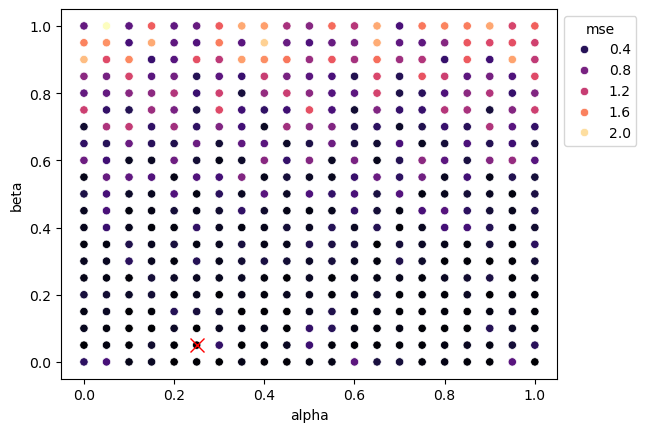

In [88]:
# Find the index of the lowest nll value
min_mse = model_fit_results.loc[model_fit_results[['mse']].idxmin()]

parameter_mse_plot = sns.scatterplot(data=model_fit_results,
                                     x="alpha", y="beta", hue="mse", palette='magma')
sns.move_legend(parameter_mse_plot, "upper left", bbox_to_anchor=(1, 1))

parameter_mse_plot.plot(min_mse['alpha'],min_mse['beta'],'x',ms=10,mec='r',mfc='none')

Red X indicates the best combination of alpha and beta for the lowest MSE.

## Model Recovery
Now we will try to see if our models will produce known alpha and beta parameters. We will simulate a list of alpha and betas (indicating one pair for each fake participant), and feed it into our model. Then we will use the simulated reaction times to fit back into the model to see if the fitted parameters match the original simulated parameters.

In [81]:
from scipy import stats

In [89]:
model_2

,SimPeer,DisPeer,Computer,Peer,Interest,Feedback,RPE,RT,n_sim,trial
0,0.5,0.5,0.5,SimPeer,2,1,0.500000,1.208908,0,0
1,0.55,0.5,0.5,SimPeer,2,1,0.450000,0.777532,0,1
2,0.595,0.5,0.5,Computer,1,1,0.500000,1.627139,0,2
3,0.595,0.5,0.55,SimPeer,1,1,0.405000,1.418223,0,3
4,0.6355,0.5,0.55,Computer,1,1,0.450000,1.973082,0,4
...,...,...,...,...,...,...,...,...,...,...
91,0.737951,0.179653,0.477943,Computer,-1,-1,-0.477943,1.454935,999,91
92,0.737951,0.179653,0.430149,SimPeer,1,1,0.262049,1.178790,999,92
93,0.764156,0.179653,0.430149,Computer,2,1,0.569851,1.239091,999,93
94,0.764156,0.179653,0.487134,SimPeer,1,1,0.235844,0.822441,999,94


In [120]:
# simulate subjects' alpha and theta params
alpha_sim = stats.truncnorm.rvs((.1),
                                (1-.25),
                                loc=.25,
                                scale=1,
                                size=(50))
beta_sim = stats.truncnorm.rvs((.1),
                                (1-.25),
                                loc=.25,
                                scale=1,
                                size=(50))

# initialize lists to store params and data
mse_sim = []
Q_fit = []
alpha_fit = []
beta_fit = []

# loop over subjects
for subj in range(50):
    np.random.seed(subj)
    
    alpha = alpha_sim[subj]
    beta = beta_sim[subj]
    
    # simulate subject data based on alpha, theta
    #c_sim, r_sim, Q_sim = simulate_RescorlaWagner([alpha, theta], T, mu);
    model_data, model_data_long = run_rl_model(model=rw_randrt_model, alpha=alpha, beta=beta, neg_reward=False,
                                     n_trials=96, n_sims=1)
    
    # gradient descent to minimize neg LL
    res_mse = np.inf
    
    # guess several different starting points for alpha
    for alpha_guess in np.arange(0,1.05,.05):

        for beta_guess in np.arange(0,1.05,.05):
        
            # guesses for alpha will change
            # guesses for theta will be constant
            init_guess = (alpha_guess, beta_guess)
            
            # minimize neg LL
            result = minimize(fit_model, init_guess, 
                              args=(len(actual_rt), rw_randrt_model, model_data['RT']), 
                              bounds=((0,1),(0,1)))
            
            # if current negLL is smaller than the last negLL,
            # then store current data
            if result.fun < res_mse:
                res_mse = result.fun
                param_fits = result.x
                #Q_vals = Q_sim
    
    # append model fits to lists
    mse_sim.append(res_mse)
    #Q_fit.append(Q_vals)
    alpha_fit.append(param_fits[0])
    beta_fit.append(param_fits[1])
    

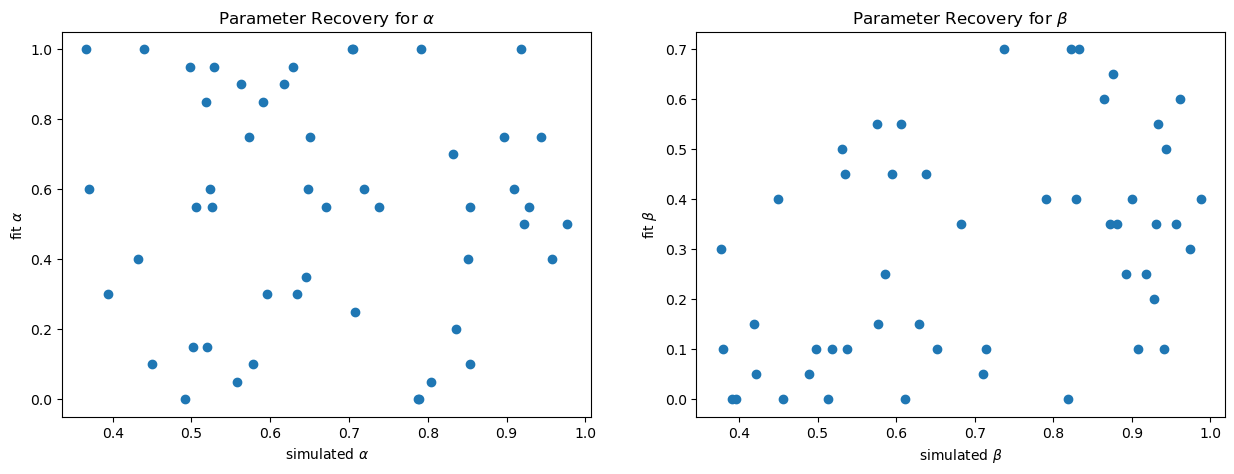

In [121]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# parameter recovery for alpha
axes[0].plot(alpha_sim, alpha_fit, 'o')
axes[0].set(ylabel=r'fit $\alpha$',
            xlabel=r'simulated $\alpha$',
            title=fr'Parameter Recovery for $\alpha$')

axes[1].plot(beta_sim, beta_fit, 'o')
axes[1].set(ylabel=r'fit $\beta$',
            xlabel=r'simulated $\beta$',
            title=fr'Parameter Recovery for $\beta$')
plt.show()

In [125]:
np.corrcoef(alpha_sim,beta_fit)[0,1]

-0.015427308375037163

In [126]:
np.corrcoef(beta_sim,beta_fit)[0,1]

0.4313820995624895

In [127]:
np.corrcoef(alpha_fit,beta_fit)[0,1]

0.07566926309670365

The correlation between the simulated and fitted alphas is -0.01, indcating a failure to recover the parameter. The correlation between the simulated and fitted betas is 0.43, indicating a strong recovery of the parameter. The correlation between the fitted alpha and betas is 0.08, which is a desired weak correlation. 

## Model Fitting

### Fit Real Data

### Parameter Fits

## Model Comparison

## Model Validation

***

# Single Subject Analysis
Ignore this

In [ ]:
subj = 'SCN_101'

# Find data for all runs
run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
run_files.sort()
run_files

In [ ]:
all_run_data = pd.DataFrame()

for file in run_files:
    if 'original' in file:
        continue
    temp_run = pd.read_csv(file, index_col=0)
    all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

# Create column for peer info
all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

# Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

# Mark missed response trials with NaN for the feedback (because no feedback was given)
all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan


all_run_data.head()

In [ ]:
all_run_data[all_run_data['ConditionName'] == 'SimPeer']

In [ ]:
rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4))

sns.lineplot(rl_output[['SimPeer', 'DisPeer', 'Computer']], dashes=False, ax=ax1)
ax1.set_ylabel('Condition Value')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1,1), labels=['Similar Peer','Dissimilar Peer', 'Computer'])

sns.lineplot(rl_output['RPE'], dashes=False, ax=ax2)
ax2.set_ylabel('Reward Prediction Error')

plt.subplots_adjust(wspace=0.8)

# All Subjects

In [ ]:
for subj in subj_list:
    subj_outp_dir = os.path.join(outp_dir, subj)
    if not os.path.exists(subj_outp_dir):
        os.makedirs(subj_outp_dir)
    
    run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
    run_files.sort()
    
    if len(run_files) == 0:
        continue
    
    
    all_run_data = pd.DataFrame()

    for file in run_files:
        if 'original' in file:
            run_files.remove(file)
            continue
        temp_run = pd.read_csv(file, index_col=0)
        all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

    # Create column for peer info
    all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

    # Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
    all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
    all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

    # Mark missed response trials with NaN for the feedback (because no feedback was given)
    all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan
    
    
    rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)
    rl_output.to_csv(os.path.join(subj_outp_dir, 'rl_output-all_runs.csv'), index=False)
    
    for file in run_files:
        run_str = file.split('Run')[1][0]
        temp_run_data = all_run_data_rl[all_run_data_rl['Run'] == int(run_str)]
        temp_file_name = file.split('/')[-1]
        temp_run_data.to_csv(os.path.join(subj_outp_dir, temp_file_name), index=False)